<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Exam_preparation/cnn_food101_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

--2021-09-12 13:05:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 209.85.234.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   162MB/s    in 3.1s    

2021-09-12 13:05:13 (162 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
!wget https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/helper_functions.py

--2021-09-12 13:05:13--  https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5005 (4.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   4.89K  --.-KB/s    in 0s      

2021-09-12 13:05:13 (47.1 MB/s) - ‘helper_functions.py’ saved [5005/5005]



# Data preparation

## Unzip data

In [3]:
import zipfile

#Unzip the data
zip_ref = zipfile.ZipFile("/content/10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
import os

#Check how many directories and images in unzipped file
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"{len(dirpath)} directories containing {len(filenames)} in {dirpath}")

24 directories containing 0 in 10_food_classes_all_data
30 directories containing 0 in 10_food_classes_all_data/train
36 directories containing 750 in 10_food_classes_all_data/train/steak
36 directories containing 750 in 10_food_classes_all_data/train/pizza
44 directories containing 750 in 10_food_classes_all_data/train/chicken_curry
36 directories containing 750 in 10_food_classes_all_data/train/ramen
44 directories containing 750 in 10_food_classes_all_data/train/chicken_wings
41 directories containing 750 in 10_food_classes_all_data/train/fried_rice
40 directories containing 750 in 10_food_classes_all_data/train/ice_cream
45 directories containing 750 in 10_food_classes_all_data/train/grilled_salmon
36 directories containing 750 in 10_food_classes_all_data/train/sushi
40 directories containing 750 in 10_food_classes_all_data/train/hamburger
29 directories containing 0 in 10_food_classes_all_data/test
35 directories containing 250 in 10_food_classes_all_data/test/steak
35 directories

In [5]:
test_dir = "/content/10_food_classes_all_data/test/"
train_dir = "/content/10_food_classes_all_data/train/"

## Visualize data

In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [7]:
#Get class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 384, 3)


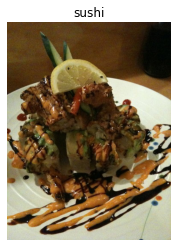

In [8]:
img = view_random_image(train_dir, random.choice(class_names))

## Preprocess data - Image DataGenerator with Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Rescale data and create generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

#Load data from directories
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir, 
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [13]:
train_data_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True)

train_data_augmented = train_data_augmented.flow_from_directory(train_dir,
                                                                target_size=(224,224),
                                                                batch_size=32,
                                                                class_mode="categorical")

Found 7500 images belonging to 10 classes.


# Modelling experiments

In [35]:
def plot_training_curve(history):
  plt.figure(figsize=(10,7))
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  plt.plot(loss, label="loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend()
  plt.title("Loss")
  plt.figure(figsize=(10,7))
  plt.plot(accuracy, label="accuracy")
  plt.plot(val_accuracy, label="val_accuracy")
  plt.legend()
  plt.title("Accuracy")

## Model 0: Baseline

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

#Build the model 

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(10, 3, activation="relu")(inputs)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(10, 3, activation="relu")(inputs)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_0 = tf.keras.Model(inputs, outputs)

In [11]:
#Compile the model 
model_0.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [14]:
#Fit the model 
history_model_0 = model_0.fit(train_data_augmented,
                              epochs=5,
                              validation_data=test_data)

Epoch 1/5
235/235 [==============================] - 127s 542ms/step - loss: 2.2289 - accuracy: 0.2188 - val_loss: 1.9769 - val_accuracy: 0.3264
Epoch 2/5
235/235 [==============================] - 126s 538ms/step - loss: 2.0935 - accuracy: 0.2647 - val_loss: 1.9108 - val_accuracy: 0.3484
Epoch 3/5
235/235 [==============================] - 125s 534ms/step - loss: 2.0327 - accuracy: 0.2940 - val_loss: 1.9843 - val_accuracy: 0.3028
Epoch 4/5
235/235 [==============================] - 130s 552ms/step - loss: 1.9825 - accuracy: 0.3079 - val_loss: 1.8825 - val_accuracy: 0.3540
Epoch 5/5
235/235 [==============================] - 127s 542ms/step - loss: 1.9584 - accuracy: 0.3283 - val_loss: 1.9255 - val_accuracy: 0.3584


In [15]:
#Evaluate the model 
model_0.evaluate(test_data)

79/79 [==============================] - 12s 155ms/step - loss: 1.9255 - accuracy: 0.3584


[1.9254814386367798, 0.35839998722076416]

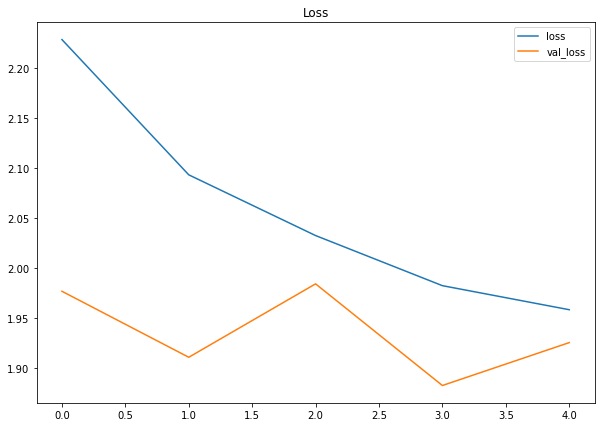

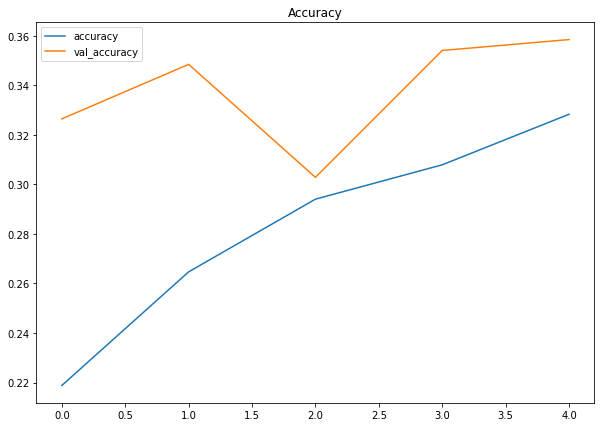

In [36]:
#Plot loss curves
plot_training_curve(history_model_0)

## Model 1: Feature Extraction

### Create faster Datasets

In [25]:
#Create faster datasets
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


###Create data augmentation layer

In [27]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomFlip("horizontal"),
                                         preprocessing.RandomRotation(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2)
])

In [19]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [38]:
tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [39]:
#Compile the model 
model_1.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [40]:
#Fit the model 
history_model_1 = model_1.fit(train_data,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)))

Epoch 1/5
235/235 [==============================] - 68s 258ms/step - loss: 1.0127 - accuracy: 0.6673 - val_loss: 0.4749 - val_accuracy: 0.8536
Epoch 2/5
235/235 [==============================] - 57s 240ms/step - loss: 0.6517 - accuracy: 0.7849 - val_loss: 0.4006 - val_accuracy: 0.8602
Epoch 3/5
235/235 [==============================] - 54s 228ms/step - loss: 0.5856 - accuracy: 0.8061 - val_loss: 0.4104 - val_accuracy: 0.8684
Epoch 4/5
235/235 [==============================] - 53s 225ms/step - loss: 0.5413 - accuracy: 0.8235 - val_loss: 0.3713 - val_accuracy: 0.8750
Epoch 5/5
235/235 [==============================] - 51s 217ms/step - loss: 0.4943 - accuracy: 0.8379 - val_loss: 0.3849 - val_accuracy: 0.8750


In [41]:
#Evaluate 
model_1.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.3528 - accuracy: 0.8824


[0.35277798771858215, 0.8823999762535095]

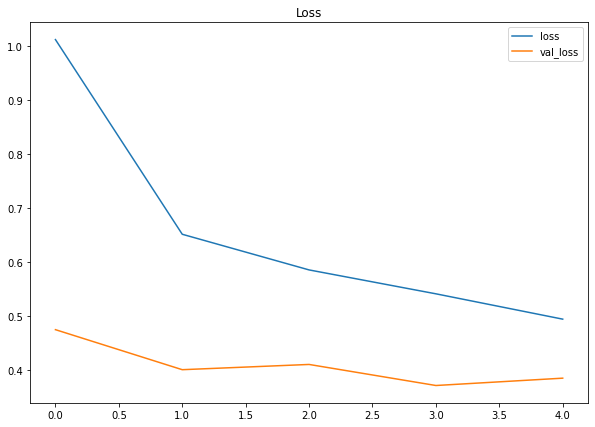

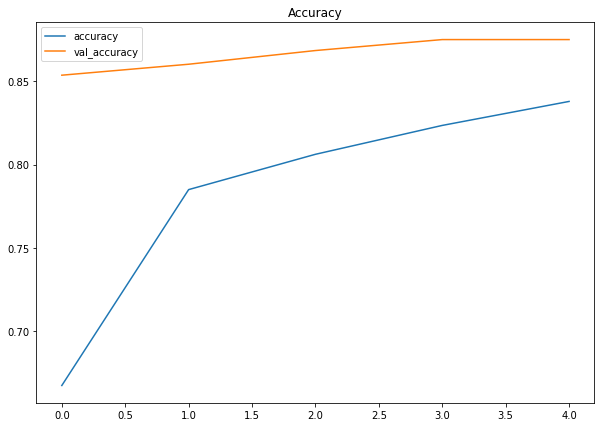

In [42]:
#Plot loss curves
plot_training_curve(history_model_1)

## Model 2: Fine Tuning

In [43]:
tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [44]:
#Compile the model 
model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [45]:
#Fit the model 
history_model_2 = model_2.fit(train_data,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)))

Epoch 1/5
235/235 [==============================] - 58s 215ms/step - loss: 1.0006 - accuracy: 0.6720 - val_loss: 0.4367 - val_accuracy: 0.8586
Epoch 2/5
235/235 [==============================] - 50s 209ms/step - loss: 0.6497 - accuracy: 0.7871 - val_loss: 0.4021 - val_accuracy: 0.8766
Epoch 3/5
235/235 [==============================] - 47s 197ms/step - loss: 0.5870 - accuracy: 0.8113 - val_loss: 0.3533 - val_accuracy: 0.8799
Epoch 4/5
235/235 [==============================] - 48s 201ms/step - loss: 0.5271 - accuracy: 0.8256 - val_loss: 0.3636 - val_accuracy: 0.8668
Epoch 5/5
235/235 [==============================] - 47s 197ms/step - loss: 0.4942 - accuracy: 0.8403 - val_loss: 0.3590 - val_accuracy: 0.8898


In [46]:
#Evaluate 
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.3278 - accuracy: 0.8936


[0.3277633488178253, 0.8935999870300293]

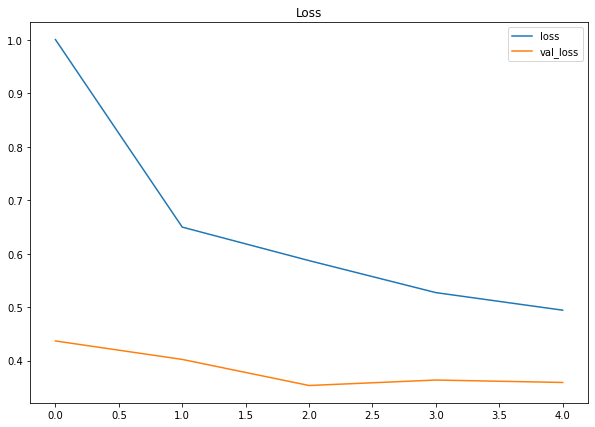

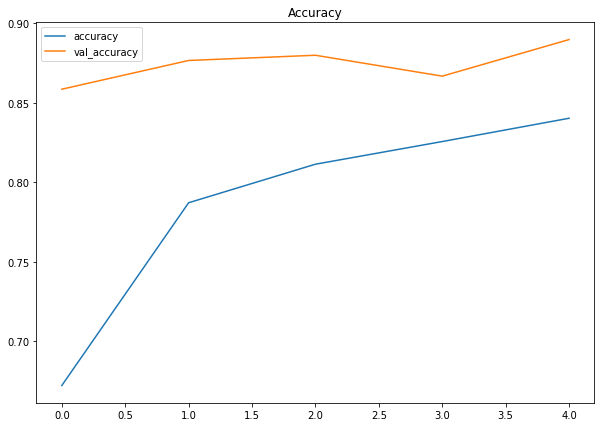

In [47]:
#Plot loss curves
plot_training_curve(history_model_2)

In [48]:
#Unfreeze all layers
base_model.trainable = True

#Freeze all layers except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [49]:
#Compile the model 
model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [52]:
# What layers in the model are trainable?
for layer in model_2.layers:
  print(layer.name, layer.trainable)


input_7 True
sequential True
efficientnetb0 True
global_average_pooling2d_4 True
dense_7 True
dense_8 True
dense_9 True


In [53]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [54]:
history_model_2_fine_tune = model_2.fit(train_data,
                                        epochs=10,
                                        validation_data=test_data,
                                        validation_steps=int(0.25*len(test_data)),
                                        initial_epoch=history_model_2.epoch[-1])

Epoch 5/10
235/235 [==============================] - 58s 212ms/step - loss: 0.6633 - accuracy: 0.7864 - val_loss: 0.4384 - val_accuracy: 0.8668
Epoch 6/10
235/235 [==============================] - 47s 195ms/step - loss: 0.4894 - accuracy: 0.8404 - val_loss: 0.3256 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 46s 194ms/step - loss: 0.4133 - accuracy: 0.8652 - val_loss: 0.3454 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 45s 190ms/step - loss: 0.3821 - accuracy: 0.8723 - val_loss: 0.3310 - val_accuracy: 0.8947
Epoch 9/10
235/235 [==============================] - 46s 192ms/step - loss: 0.3353 - accuracy: 0.8853 - val_loss: 0.3258 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 44s 186ms/step - loss: 0.2980 - accuracy: 0.9044 - val_loss: 0.3296 - val_accuracy: 0.8931


In [55]:
#Evaluate
model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.3318 - accuracy: 0.8984


[0.33176159858703613, 0.8984000086784363]

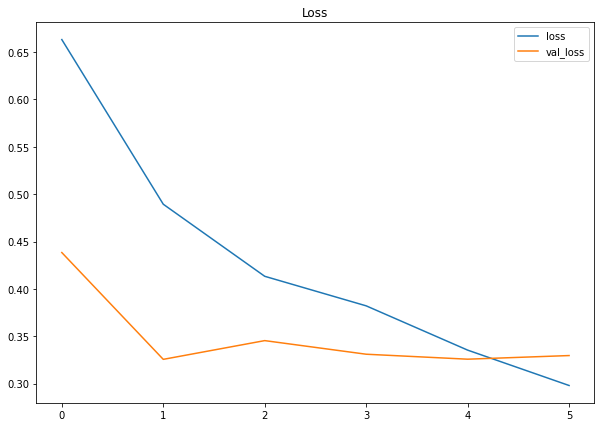

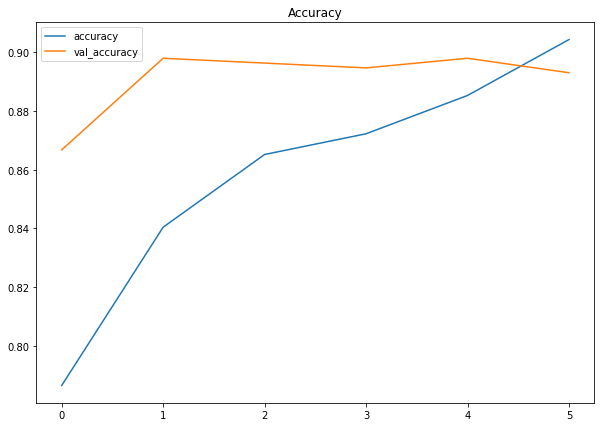

In [56]:
#Plot loss curves
plot_training_curve(history_model_2_fine_tune)